In [1]:
import requests
import json
import csv
from bs4 import BeautifulSoup
import traceback
import cloudscraper
import pandas as pd
import numpy as np
import seaborn as sns
from decimal import Decimal
from re import sub
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
#define functions 
def get_cars(
  make="BMW", 
  model="5 SERIES", 
  postcode="SW1A 0AA", 
  radius=1500, 
  min_year=1995, 
  max_year=1995, 
  include_writeoff="include", 
  max_attempts_per_page=5, 
  verbose=False,
  min_price= 0,
  max_price = 99999):

    # To bypass Cloudflare protection
    scraper = cloudscraper.create_scraper()

    # Basic variables
    results = []
    n_this_year_results = 0

    url = "https://www.autotrader.co.uk/results-car-search"

    keywords = {}
    keywords["mileage"] = ["miles"]
    keywords["BHP"] = ["BHP"]
    keywords["transmission"] = ["Automatic", "Manual"]
    keywords["fuel"] = [
      "Petrol", 
      "Diesel", 
      "Electric", 
      "Hybrid – Diesel/Electric Plug-in", 
      "Hybrid – Petrol/Electric", 
      "Hybrid – Petrol/Electric Plug-in"
    ]
    keywords["owners"] = ["owners"]
    keywords["body"] = [
      "Coupe", 
      "Convertible", 
      "Estate", 
      "Hatchback", 
      "MPV", 
      "Pickup", 
      "SUV", 
      "Saloon"
    ]
    keywords["ULEZ"] = ["ULEZ"]
    keywords["year"] = [" reg)"]
    keywords["engine"] = ["engine"]

    # Set up parameters for query to autotrader.co.uk
    params = {
        "sort": "relevance",
        "postcode": postcode,
        "price-from" : min_price,
        "price-to" : max_price,
        "radius": radius,
        "make": make,
        "model": model,
        "search-results-price-type": "total-price",
        "search-results-year": "select-year",
    }

    if (include_writeoff == "include"):
        params["writeoff-categories"] = "on"
    elif (include_writeoff == "exclude"):
        params["exclude-writeoff-categories"] = "on"
    elif (include_writeoff == "writeoff-only"):
        params["only-writeoff-categories"] = "on"
        
    year = min_year
    page = 1
    attempt = 1

    try:
        while year <= max_year:
            params["year-from"] = year
            params["year-to"] = year
            params["page"] = page

            r = scraper.get(url, params=params)
            if verbose:
                print("Year:     ", year)
                print("Page:     ", page)
                print("Response: ", r)

            try:
                if r.status_code != 200:   # If not successful (e.g. due to bot protection)
                    print(r.status_code)
                    attempt = attempt + 1  # Log as an attempt
                    if attempt <= max_attempts_per_page:
                        if verbose:
                            print("Exception. Starting attempt #", attempt, "and keeping at page #", page)
                    else:
                        page = page + 1
                        attempt = 1
                        if verbose:
                            print("Exception. All attempts exhausted for this page. Skipping to next page #", page)

                else:

                    j = r.json()
                    s = BeautifulSoup(j["html"], features="html.parser")

                    articles = s.find_all("article", attrs={"data-standout-type":""})

                    # If no results or reached end of results...
                    if len(articles) == 0 or r.url[r.url.find("page=")+5:] != str(page):
                        if verbose:
                            print("Found total", n_this_year_results, "results for year", year, "across", page-1, "pages")
                            if year+1 <= max_year:
                                print("Moving on to year", year + 1)
                                print("---------------------------------")

                        # Increment year and reset relevant variables
                        type(year)
                        year = year + 1
                        page = 1
                        attempt = 1
                        n_this_year_results = 0
                    else:
                        for article in articles:
                            car = {}
                            car["name"] = article.find("h3", {"class": "product-card-details__title"}).text.strip()             
                            car["link"] = "https://www.autotrader.co.uk" + \
                                  article.find("a", {"class": "listing-fpa-link"})["href"][: article.find("a", {"class": "listing-fpa-link"})["href"] \
                                  .find("?")]
                            car["price"] = int(sub(r'[^\d.]', '', article.find("div", {"class": "product-card-pricing__price"}).text.strip()))

                            seller_info = article.find("ul", {"class": "product-card-seller-info__specs"}).text.strip()
                            car["seller"] = " ".join(seller_info.split())

                            key_specs_bs_list = article.find("ul", {"class": "listing-key-specs"}).find_all("li")
                            
                            for key_spec_bs_li in key_specs_bs_list:

                                key_spec_bs = key_spec_bs_li.text

                                if any(keyword in key_spec_bs for keyword in keywords["mileage"]):
                                    car["mileage"] = int(key_spec_bs[:key_spec_bs.find(" miles")].replace(",",""))
                                elif any(keyword in key_spec_bs for keyword in keywords["BHP"]):
                                    car["BHP"] = int(key_spec_bs[:key_spec_bs.find("BHP")])
                                elif any(keyword in key_spec_bs for keyword in keywords["transmission"]):
                                    car["transmission"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["fuel"]):
                                    car["fuel"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["owners"]):
                                    car["owners"] = int(key_spec_bs[:key_spec_bs.find(" owners")])
                                elif any(keyword in key_spec_bs for keyword in keywords["body"]):
                                    car["body"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["ULEZ"]):
                                    car["ULEZ"] = key_spec_bs
                                elif any(keyword in key_spec_bs for keyword in keywords["year"]):
                                    car["year"] = key_spec_bs
                                elif key_spec_bs[1] == "." and key_spec_bs[3] == "L":
                                    car["engine"] = float(sub(r'[^\d.]', '', key_spec_bs))

                            results.append(car)
                            n_this_year_results = n_this_year_results + 1

                        page = page + 1
                        attempt = 1

                        if verbose:
                            print("Car count: ", len(results))
                            print("---------------------------------")

            except KeyboardInterrupt:
                break

            except:
                traceback.print_exc()
                attempt = attempt + 1
                if attempt <= max_attempts_per_page:
                    if verbose:
                        print("Exception. Starting attempt #", attempt, "and keeping at page #", page)
                else:
                    page = page + 1
                    attempt = 1
                    if verbose:
                        print("Exception. All attempts exhausted for this page. Skipping to next page #", page)

    except KeyboardInterrupt:
        pass

    return pd.DataFrame(results)

def col_select(df,column):
    final_cols = []
    for i in df.columns:
        for j in column:
            if j in i:
                final_cols.append(i)
    
    return final_cols

def grouped_score(df,group,col_name):

    df = df.reset_index()
    
    car_match_gr = df.groupby(group).sum(numeric_only= True)
    count_cm_gr = df.groupby(group).count()

    price_dif_gr = car_match_gr['price_sell'] - car_match_gr['price_buy']
    mileage_ratio_gr = car_match_gr['mileage_sell']/car_match_gr['mileage_buy']
    engine_ratio_gr = car_match_gr['engine_buy'] /car_match_gr['engine_sell']

    score_gr = price_dif_gr * mileage_ratio_gr * engine_ratio_gr * (1/count_cm_gr['price_sell'])

    score_df = df.merge(score_gr.reset_index(),how = 'left',on  = group ).rename({0:col_name},axis = 1).drop(['index'],axis = 1)

    score_df = score_df[~score_df.isin([0,'inf'])]

    return score_df

def postcode_add(df,postcode):
    for i in df.columns:
        concat_col = i + ' ' + postcode
        df = df.rename({i: concat_col.replace(' ','_')}, axis=1)

    return df

def retrieve_cars(make, model, postcode, radius, min_year, max_year, min_price, max_price,location_type):
    """
    Retrieve car listings based on specified search parameters.
    """
    cars = get_cars(
        make=make,
        model=model,
        postcode=postcode,
        radius=radius,
        min_year=min_year,
        max_year=max_year,
        min_price=min_price,
        max_price=max_price
    )
    # Clean up year and brand columns
    cars['year'] = cars['year'].dropna().apply(lambda x: int(str(x).split('(')[0]))
    cars['brand'] = cars['name'].apply(lambda x: x.split(' ')[0])
    cars['postcode'] = postcode
    cars = postcode_add(cars,location_type)
    return cars
#grouped_score(car_match,'index','buy_score')

In [42]:
#### parameters needed #####
#location 1 and location 2 to compare
#radius for each 
#car price and comparison
#minimum and maximum purchase price 

In [45]:
#leave as blank to include all within that range 
#postcode as 10 
#loation 1 is the area to buy the car and 2 is to sell 

make_buy="" 
model_buy="" 
postcode_buy="MK3 6JS" 
radius_buy=30
min_year_buy=2005 
max_year_buy=2010 
min_price_buy=10
max_price_buy = 10000

make_sell="" 
model_sell="" 
postcode_sell="DT1 3GJ" 
radius_sell=30
min_year_sell=2005 
max_year_sell=2010 
min_price_sell=10
max_price_sell = 10000


location_buy = retrieve_cars(make = make_buy, 
                           model = model_buy,
                           postcode = postcode_buy,
                           radius = radius_buy ,
                           min_year = min_year_buy ,
                           max_year = max_year_buy ,
                           min_price = min_price_buy,
                           max_price = max_price_buy,
                           location_type = 'buy' )

location_sell = retrieve_cars(make = make_sell, 
                           model = model_sell,
                           postcode = postcode_sell,
                           radius = radius_sell ,
                           min_year = min_year_sell ,
                           max_year = max_year_sell ,
                           min_price = min_price_sell,
                           max_price = max_price_sell,
                           location_type = 'sell' )

location_buy.to_csv('location_buy.csv')
location_sell.to_csv('location_sell.csv')



In [77]:
location_buy = pd.read_csv('location_buy.csv').drop('Unnamed: 0',axis = 1)
location_sell = pd.read_csv('location_sell.csv').drop('Unnamed: 0',axis = 1)

car_match = location_buy.merge(location_sell, how = 'inner', left_on = col_select(location_buy,['name','year']),
                       right_on = col_select(location_sell,['name','year']))

car_match = grouped_score(car_match,'index','buy_score')
car_match = grouped_score(car_match,'name_buy','score_by_name')
car_match = grouped_score(car_match,'brand_buy','score_by_brand')

In [80]:
#top 10 cars and urls
car_match.sort_values(by = 'buy_score' ,ascending= False)[0:20][['name_buy','price_buy','price_sell','postcode_buy','postcode_sell','mileage_buy','mileage_sell','engine_buy','engine_sell','buy_score','score_by_brand','score_by_name','link_buy','link_sell']]

,name_buy,price_buy,price_sell,postcode_buy,postcode_sell,mileage_buy,mileage_sell,engine_buy,engine_sell,buy_score,score_by_brand,score_by_name,link_buy,link_sell
4195,Ford Fiesta,2790,5695,MK3 6JS,DT1 3GJ,105000.0,41000.0,1.4,NaN,inf,654.386772,797.998373,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...
1329,Ford Fiesta,2900,2990,MK3 6JS,DT1 3GJ,114000.0,85000.0,1.6,NaN,inf,654.386772,797.998373,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...
1428,Ford Fiesta,1795,2495,MK3 6JS,DT1 3GJ,111500.0,82000.0,1.4,NaN,inf,654.386772,797.998373,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...
1497,Ford Fiesta,2595,2990,MK3 6JS,DT1 3GJ,113233.0,85000.0,1.4,NaN,inf,654.386772,797.998373,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...
4095,Ford Fiesta,3899,5695,MK3 6JS,DT1 3GJ,89729.0,41000.0,1.4,NaN,inf,654.386772,797.998373,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...
3653,Toyota Yaris,3490,4695,MK3 6JS,DT1 3GJ,51522.0,70000.0,1.0,NaN,inf,-143.776938,-352.771386,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...
1035,Ford Fiesta,2000,2490,MK3 6JS,DT1 3GJ,110546.0,94000.0,1.2,NaN,inf,654.386772,797.998373,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...
1164,Ford Focus,1290,2495,MK3 6JS,DT1 3GJ,NaN,129000.0,1.8,1.8,inf,654.386772,110.151075,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...
1013,Ford Fiesta,1499,4495,MK3 6JS,DT1 3GJ,102298.0,14491.0,1.4,NaN,inf,654.386772,797.998373,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20221...
4075,Ford Fiesta,4290,5695,MK3 6JS,DT1 3GJ,80000.0,41000.0,1.6,NaN,inf,654.386772,797.998373,https://www.autotrader.co.uk/car-details/20230...,https://www.autotrader.co.uk/car-details/20230...


<BarContainer object of 4 artists>

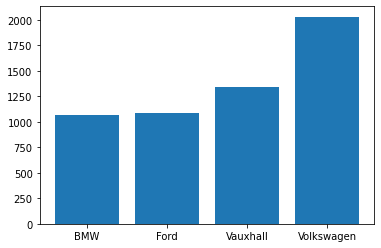

In [19]:
plt.bar(x = score_gr.index,height = score_gr.values)